This notebook aims to go through a basic implementation of the gradient boosting algorithm with a Bayesian twist, using decision trees as our base estimator.  First we need to import 

In [44]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle,resample
import pymc3 as pm
import logging
logging.getLogger("pymc3").setLevel(logging.WARNING)

In [45]:
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * .9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
xi = X_train
yi = y_train

In [15]:
ei = 0 # initialization of error
predf = 0 # initial prediction 0
count = 1 # initial count we will reference 
test_predictions = 0 # initial test set prediction 0
mse_list_adap = [] #Creating the mse data set
lr = .01 #Setting the Learning rate
test_predictions_list = pd.DataFrame([])
mcmc_learning_rates = pd.DataFrame([])

In [16]:
for i in range(250): # loop will make n trees, the more trees that are built increases complexity
                     #and the liklihood of overfitting.

    
    tree = DecisionTreeRegressor(max_depth=2)
    tree.fit(xi,yi)
    predi =  tree.predict(xi)
    predicted =  tree.predict(X_test)
    
    
    if count > 2:
        data = dict(x=ei, y=predf)
        with pm.Model() as model:


             pm.glm.GLM.from_formula('y ~ x', data)

             trace = pm.sample(1000,
                               init = 'jitter+adapt_diag',
                               tune = 1000, cores=2,
                               progressbar = False,
                               verbose=0)
        mcmc_learning_rates = pd.concat([mcmc_learning_rates,pm.trace_to_dataframe(trace).iloc[:,1].tail(500)],
                                        ignore_index = True, axis = 1)


        lr = np.mean(pm.trace_to_dataframe(trace).iloc[:,1].tail(500))
    #The first model is just the median, subsequent models will be trees built on the residuals
    if count < 2:
        predf = np.median(yi)
        test_predictions = np.median(yi)
    else:
        predf = predf + lr*predi  # final prediction will be previous prediction value + new prediction on pseudoresidual
        test_predictions = test_predictions + lr*predicted
        test_predictions_list = pd.concat([test_predictions_list,pd.DataFrame(test_predictions)],
                                          ignore_index = True, axis = 1)

    ei = y_train - predf  # Obtain Pseudoresiduals    
    yi = ei # Update yi as Psuedoresidual to reloop

    count = count + 1
    test_mse = (np.mean((y_test - test_predictions)**2)) #Calculate MSE
    mse_list_adap.append(test_mse)

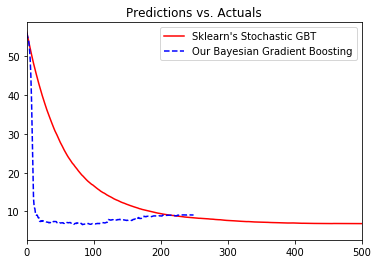

In [17]:
#List of the MSE's for each iteration
mse_list_adap = pd.DataFrame(mse_list_adap)

from sklearn.ensemble import GradientBoostingRegressor
n_est = 5000
rnd_reg = GradientBoostingRegressor(max_depth=2,
                                    n_estimators=n_est,
                                    subsample = .9,
                                    learning_rate=.01)
rnd_reg.fit(X_train,y_train)
predictions = rnd_reg.predict(X_test)
test_score = np.zeros((n_est,), dtype=np.float64)

for i, y_pred in enumerate(rnd_reg.staged_predict(X_test)):
    test_score[i] = (np.mean((y_test - y_pred)**2))

    

plt.plot(test_score, label = "Sklearn's Stochastic GBT", color = 'red')
plt.plot(mse_list_adap, label = 'Our Bayesian Gradient Boosting',
         color = 'blue', linestyle = 'dashed')
plt.xlim(0,500)
plt.legend()
plt.title('Predictions vs. Actuals')
plt.show()

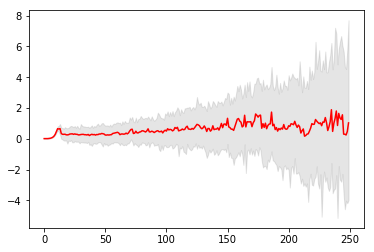

In [18]:
appendme = pd.DataFrame([.01,.01])
max_mcmc = (pd.DataFrame(np.max(mcmc_learning_rates, axis = 0)))
max_mcmc = appendme.append(max_mcmc, ignore_index = True)

appendme = pd.DataFrame([.01,.01])
min_mcmc = (pd.DataFrame(np.min(mcmc_learning_rates, axis = 0)))
min_mcmc = appendme.append(min_mcmc, ignore_index = True)

appendme = pd.DataFrame([.01,.01])
average_mcmc = pd.DataFrame(np.mean(mcmc_learning_rates,axis = 0))
average_mcmc = appendme.append(average_mcmc, ignore_index = True)


values = np.squeeze(pd.DataFrame(max_mcmc.index.values))
plt.plot(values,average_mcmc, color = 'red')
plt.fill_between(values,np.squeeze(max_mcmc),np.squeeze(min_mcmc), alpha = .2, color = 'grey')
plt.show()

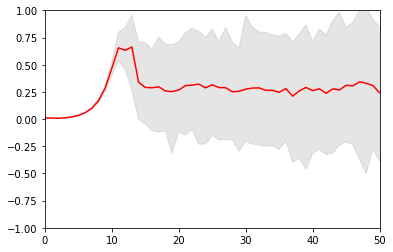

In [19]:
plt.plot(values,average_mcmc, color = 'red')
plt.fill_between(values,np.squeeze(max_mcmc),np.squeeze(min_mcmc), alpha = .2, color = 'grey')
plt.xlim(0,50)
plt.ylim(-1,1)
plt.show()

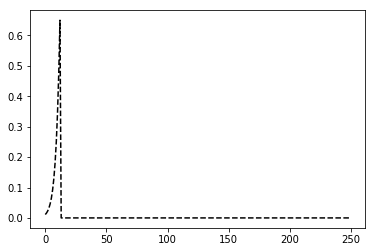

In [169]:
from scipy.stats import beta
Beta_LearningRate = []
for i in range(250):
    Beta_LearningRate.append(2*beta.pdf(i,26,1, scale=80, loc=-68)) 
plt.plot(Beta_LearningRate, color = 'black', linestyle = 'dashed')
plt.show()

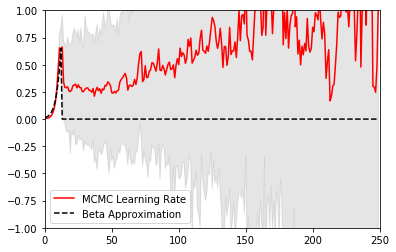

In [170]:
plt.plot(values,average_mcmc, color = 'red', label = 'MCMC Learning Rate')
plt.fill_between(values,np.squeeze(max_mcmc),np.squeeze(min_mcmc), alpha = .2, color = 'grey')
plt.xlim(0,250)
plt.ylim(-1,1)
plt.plot(Beta_LearningRate, color = 'black', linestyle = 'dashed', label = 'Beta Approximation')
plt.legend()
plt.show()